In [2]:
import numpy as np
import csv
import cv2
import random
import matplotlib.pylab as plt
%matplotlib inline
from data_adaptation import *

## Reading in Data

Let's start by reading the data provided by udacity and taking a look at it. I'll copy that to data to example to use.

In [96]:
lines = []
data_folder = './data_ud/'
with open(data_folder + 'driving_log.csv') as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        lines.append(line)

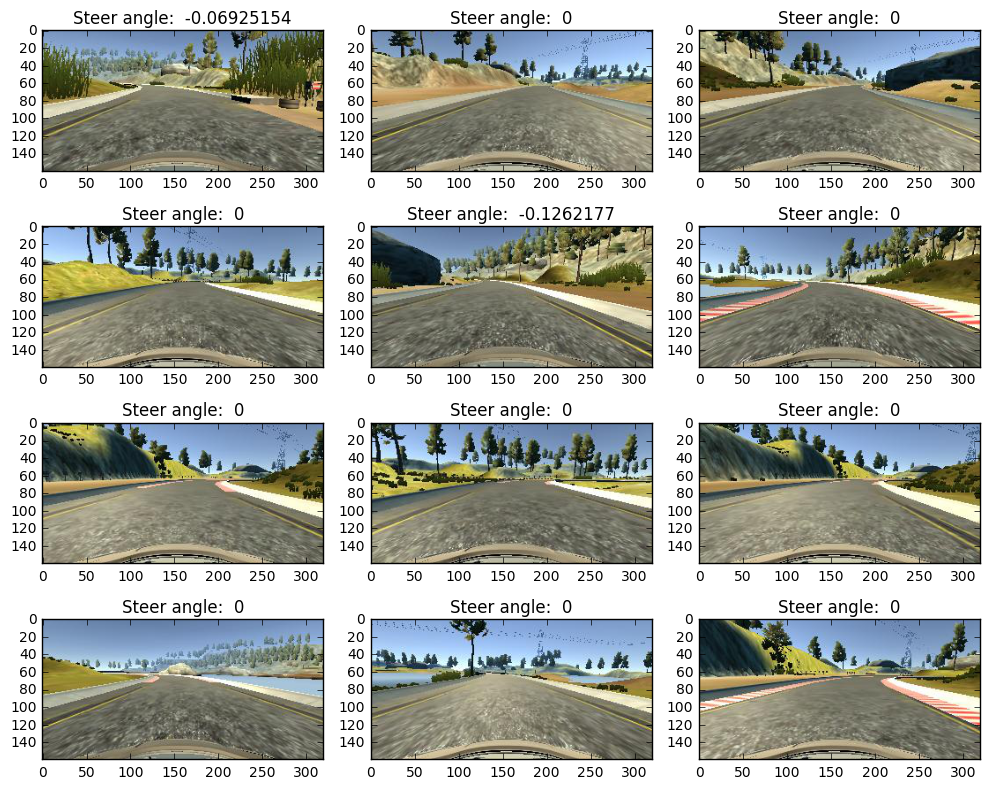

In [97]:
# list of samples for reference
example_lines = []
n = 4
m = 3
fig, ax = plt.subplots(n, m)
for a, sample in zip(ax.flatten(),range(n * m)):
    selected_test = np.random.randint(0, len(lines))
    line = lines[selected_test]
    example_lines.append(line)
    img = cv2.imread(data_folder + line[0].strip())
    a.imshow(toRGB(img))
    a.set_title('Steer angle: ' + line[3])
fig.set_size_inches(10,8)
fig.tight_layout()

## Simple Augmented LeNet

I started by creating a simple LeNet architecture with some extra filters to get a filling on the behavior of the car. That didn't work well and the car had difficulties turning. It does not seem to be a problem with the capacity of the net as I increased the number of filters available. I tried several configurations without much success. The network did not seem to overfit the data since its validation loss was not increasing.

### Data Augmentation

For that test, I used Udacity's provided data. In order to keep training times low, I choose 1000 random lines in the log file. The samples are treated by cropping 55 pixels from the top and 20 pixels from the bottom. Also, I created vertically flipped image and I also inverted the steering measurement.

For left and right images, I added a correction to the steering measurement. All in all, I had 6000 samples.

I was not expecting to drive all the way around with this net, but the car seemed to have problems detecting curves.

## Bias Problem

Looking at the images, it seem clear that there is a very high bias towards a steering angle of 0. Even in cases where the car is close to the side of the road. That may be one reason my first attemps at fitting a simple architecture similar to LeNet were so unsuccessful. Even using all the data available I could not get it to perform well.

For that reason went on to do some selection on the data instead of choosing it randomly. To do that, it is good to first analyze it numerically to confirm our intuition. I also read about other people having similar difficulties, therefore it seemed worth a try.

In [6]:
# Let's read all angles
angles_list = []
for line in lines[1:]:
    angles_list.append(float(line[3].strip()))

angles = np.array(angles_list)
print('Some statistics:')
print('Mean:', np.mean(angles))
print('Standar deviation:', np.std(angles))
print('Maximum', np.max(angles))
print('Minimun', np.min(angles))

Some statistics:
Mean: 0.00406964406483
Standar deviation: 0.128832055818
Maximum 1.0
Minimun -0.9426954


<a list of 50 Patch objects>

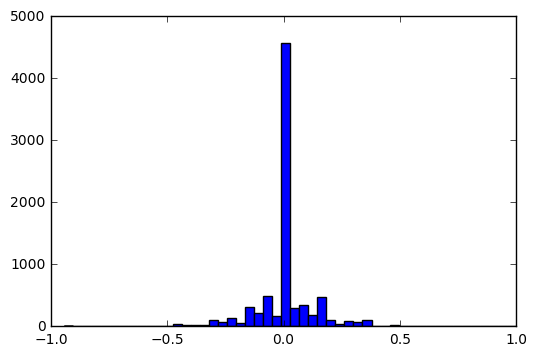

In [7]:
hist = plt.hist(angles, 50)
hist[2]

That histogram leaves no room for doubt. Selecting samples at random would most likely give a very bad representation of the poulation. It seems to explain also how I got quite different results from trainning twice the same architectures.
Since I'm trying to limit the amount of samples to something that I can run localy, it makes seem to select them better. Let's start by checking some extremes.

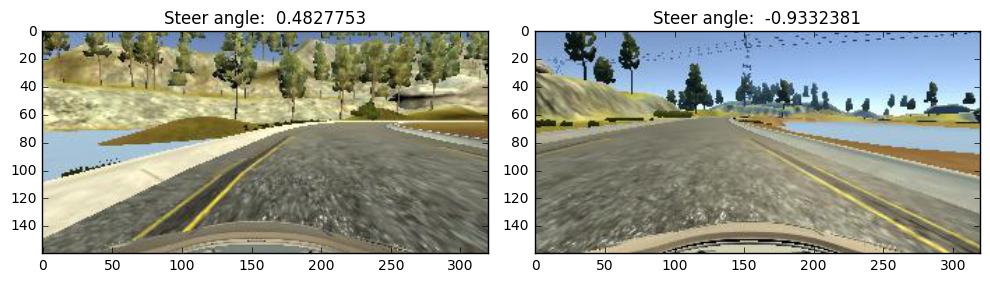

In [8]:
max_frame = np.argmax(angles)
min_frame = np.argmin(angles)

fig, ax = plt.subplots(1, 2)
line = lines[max_frame]
img = cv2.imread(data_folder + line[0].strip())
ax[0].imshow(toRGB(img))
ax[0].set_title('Steer angle: ' + line[3])
line = lines[min_frame]
img = cv2.imread(data_folder + line[0].strip())
ax[1].imshow(toRGB(img))
ax[1].set_title('Steer angle: ' + line[3])
fig.set_size_inches(10,8)
fig.tight_layout()

It seems that the steering angles may be normalized

In [9]:
chopped_index = (np.abs(angles)<1)
chopped_lines = np.array(lines[1:])[chopped_index]
chopped_angles = angles[chopped_index]

There seems to be a lot of samples where the steering angle is just 0. That can be dealt later on with some small threshold while driving. For that reason, we do not need many samples that just drive straight.

In [10]:
print('Number of samples with steering equal to zero', len(angles[angles==0]))

Number of samples with steering equal to zero 4361


That represents more than half the samples. No wonder the car has a tendency to drive straight. Lets take out the mayority of them. I'll keep 100 sample points to keep some of their representation.

In [11]:
zero_angle_index = (chopped_angles == 0)
valid_angle_index= (chopped_angles != 0)
zero_angle_lines = chopped_lines[zero_angle_index]
valid_lines = chopped_lines[valid_angle_index]
valid_angles = chopped_angles[valid_angle_index]
# Select random samples from zero angle
n = 100 # number of samples to consider
idx = np.random.choice(len(zero_angle_lines) - 1, n, replace=False)
valid_lines = np.vstack((valid_lines, zero_angle_lines[idx]))
valid_angles = np.hstack((valid_angles, np.zeros(n)))

Let's check how the histogram of angles already filtered looks like

<a list of 20 Patch objects>

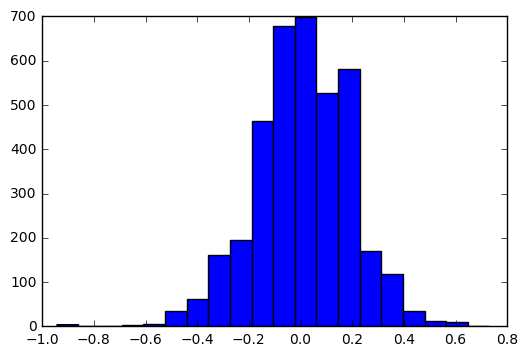

In [12]:
hist = plt.hist(valid_angles, 20)
hist[2]

It looks much mode adecuate for the task at hand. Still it is not uniform but is not as bad as it was. At this point, my idea is to train with data from about 1000 lines of the log file. If we divide 1000 samples in 20 bins we get 50 samples per bin. Some of those bins in this case don't have 50 samples, but an approximate number would sufice. Here I select a maximum of 55 random samples per bin.

In [13]:
# Selecting final samples to use
used_samples = []
samples_per_bin = 55
bin_start = min(valid_angles)
for bin_end in hist[1][1:]:
    selectable = np.where(np.logical_and(valid_angles>=bin_start, valid_angles<=bin_end))
    samples_in_bin = len(valid_angles[selectable])
    if samples_in_bin > samples_per_bin:
        idx = np.random.choice(samples_in_bin, samples_per_bin, replace=False)
        select_from = valid_lines[selectable]
        used_samples.append(select_from[idx])
    else:
        used_samples.append((valid_lines[selectable]))
    bin_start = bin_end
used_samples = np.concatenate(used_samples)

Let's see how our distribution of angles looks now that they have been filtered

<a list of 20 Patch objects>

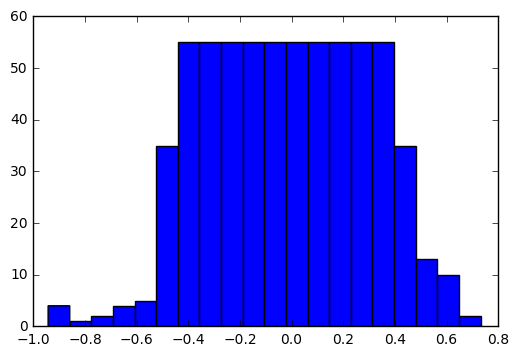

In [14]:
used_angles = np.fromiter( [line[3] for line in used_samples], float )
hist = plt.hist(used_angles, 20)
hist[2]

I put together this code in a couple of functions in data_adaptation.py. Using that functions I again trained a network similar to LeNet. The car performed a little better, but still no near well enough to go around the course. It was clearly over fitting the data. In fact, validation loss was increasing already at the second epoch. Therefore, I decided to increase the amount of samples that I feed it, I added a dropout layer and I set up a callback to keep the best model trained. In this case, I used 4000 sample lines. After augmentation, that figure represents almost 8000 frames.
The model performed surprinsinly well. It took the car all the way accross the bridge and it only got lost at the crossing with the dirt road.

Let's try to see some results.

In [98]:
from keras.models import Sequential, load_model
model = load_model('./model_LeNet.h5')

In [99]:
# Let's calculate an estimate of steering angle for a frame
img = cv2.imread(data_folder + example_lines[0][0].strip())
#a.imshow(toRGB(img))
steer_estimate = model.predict(toRGB(img)[None,:,:,:], batch_size=1)[0][0]
print(steer_estimate)

-0.174119


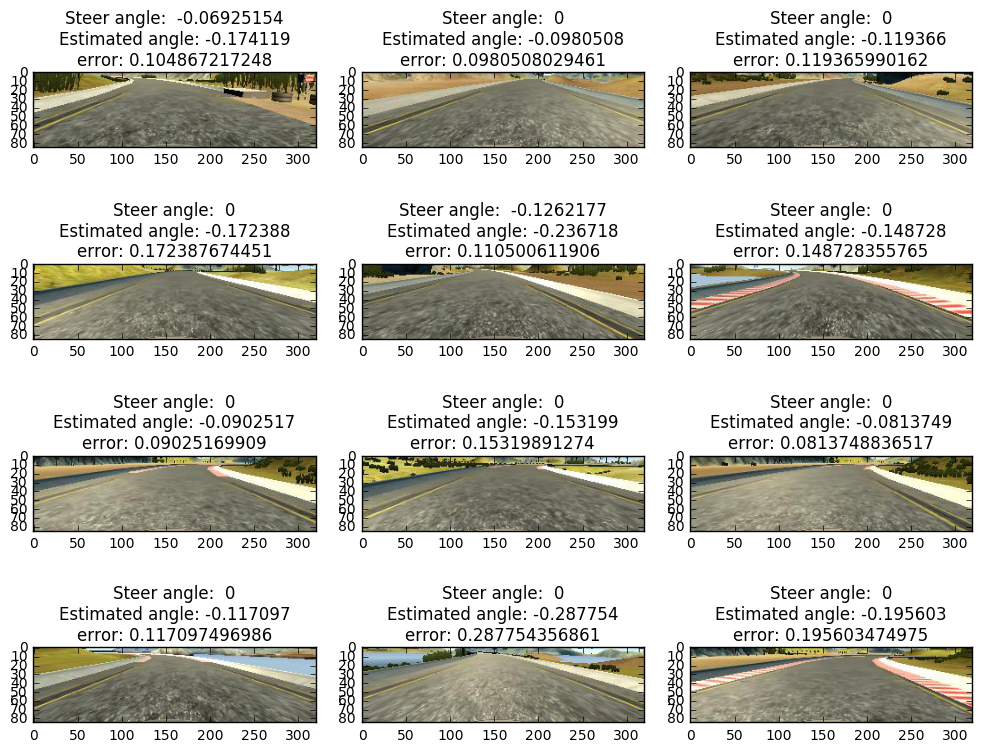

In [100]:
# Plot frames from examples list to be the same as above
n = 4
m = 3
fig, ax = plt.subplots(n, m)
for a, sample in zip(ax.flatten(), example_lines):
    img = cv2.imread(data_folder + sample[0].strip())
    # Crop images to see what the classifiers sees
    a.imshow(toRGB(img[55:140, :, :]))
    steer_estimate = model.predict(toRGB(img)[None,:,:,:], batch_size=1)[0][0]
    a.set_title('Steer angle: ' + sample[3] + '\n' + 'Estimated angle: ' + str(steer_estimate) + '\n' +
                'error: ' + str(abs(float(sample[3]) - steer_estimate)))
fig.set_size_inches(10,8)
fig.tight_layout()

By looking at the results, it seems that I may have gone too far taking out samples with steering angle equal zero. Therefore, I corrected data_adaptation to put back more samples. That in itself has no effect as I'm limiting the number of samples per angle bin. However, if I choose to train with a high number of total samples, most of the valid ones are going to be used.

There is an interesting aspect to check. We need to know if the model is expresive enough for our needs. One way of doing this is to train it with a small number of samples. We know the model should overfit. If it doesn't something is wrong.

For the case of using LeNet, the systems still has a noticeable error predicting angles. However, validation error is increasing if I keep training, a clear symptom of over-fitting. This may be caused by the capacity of the network.

To check that assumption, I went to the simulator and collected more data. In particular, I focused on the part of the track that the car could not pass.

After several attempts at training a LeNet implementation from scratch with all data available as well as training using the starting weights of the most successful net, I still could not get the car to go through that part of the track. In fact, some of its driving was quite erratic, touching on the sides at the start of the track.

For that reason, I decided to switch to a more powerful network. In this case, I started with an implementation of [AlexNet](model_AlexNet.py). After a few test, I could see that I may be having a problem over-fitting my data. Also, a full implementation of AlexNet toke quite a bit of time in training and memory. For that reason, I decided to scale down the net while keeping its architecture. I setup a scaler for the whole network of 6. I also added drop-out and L2 regularization to the fully connected layers as well as dropping the learning rate.

With this network, and after a lot of trial and error, I manage to get the car around the dirt road corner. However, it was not nearly enough to go around the course.

By that time, any new change or trail was taking quite some time in a 6 cpu i7. Memory was not a problem in my case as it is a system use for simulations so it has 32 Gb. Fitting all the data in memory was better in this case to train faster.

However, there is another route. I could try to use a pre-trained network to save some time. For that, I used keras api that very easily allows me to load a pretrained VGG. I did that in [vgg_reuse.py](./vgg_reuse.py) I wanted to train the network with as few samples as possible. For that reason, I used l2 regularization to penalize large weights and drop-out. It seemed likely that a network with quite some expressive power would tend to overfit.

I first tried to create a model that included both the VGG convolutions and the new fully connected layers. I left the convolutions layers frozen. Even though, it took a long time to do any serious training. For that reason I change my strategy. I dumped the results of applying a forward pass of VGG to my samples. Those became my features, since there is nothing in that part of the net that changes they should a valid output of VGG convolutions. With those, a trained a couple of fully connected layers.

By this time, I have quite a bit of data. Since it has already gone through the bottlenet features, it is not so computational intensive.

I made the mistake of naively use my new features to train the network. It keep getting trapped in local minimae that returned the same number for each frame. After that, I went to look at what the features look like, a novice mistake made trying to find shortcuts. When looking at that data we can see that it is very sparse. In fact, I run a small check and as many a 1044 features are zero for all sample points. That was making the network very hard to train even though I was training using 74000 frames. It is a good lesson on when more data is not useful if it has the same distribution.

Out of time, I tried to see if I could salvage some of that by using quite extreme drop-out. I set up a drop-out layer after flattening the output from VGG that keeps active only 20% of the input. That manage to alleviate the problem but network could not drive any better. In fact, it had problems turning. Again, something pointing in the direction of an unbalance data set.

Let’s see some results from this network.

In [106]:
from keras import applications
# image to check
img = cv2.imread(data_folder + example_lines[0][0].strip())

pre_model = applications.VGG16(include_top=False, input_shape=(85, 320, 3))
model = load_model('./vgg_reuse.h5')
vgg_feat = pre_model.predict(img[None, 55:140, :, :])
print('Shape of the input tensor to train our specialization network: ')
print(vgg_feat.shape[1:])
print('Input feature vector size to our networkk:')
print(int(vgg_feat[0].flatten().shape[0]))
angle_predict = model.predict(vgg_feat)
print('Predicted angle:', angle_predict[0][0])

Shape of the input tensor to train our specialization network: 
(2, 10, 512)
Input feature vector size to our networkk:
10240
Predicted angle: 0.0622753


Let’s check some outputs from this pipeline

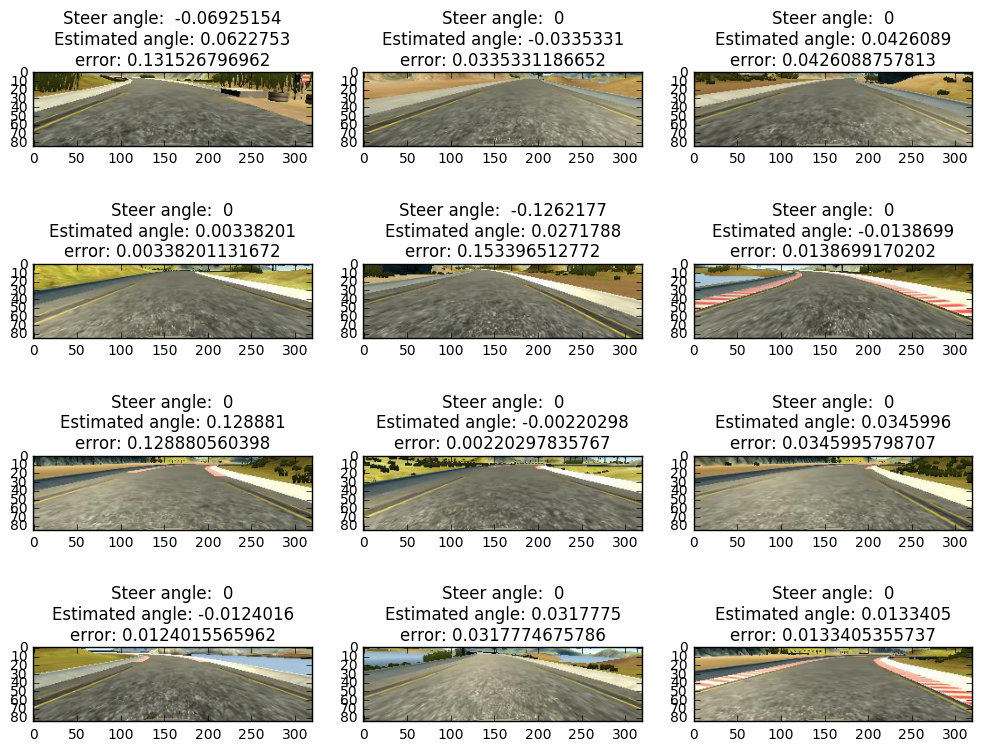

In [107]:
n = 4
m = 3
fig, ax = plt.subplots(n, m)
for a, sample in zip(ax.flatten(), example_lines):
    img = cv2.imread(data_folder + sample[0].strip())
    # Crop images to see what the classifiers sees
    a.imshow(toRGB(img[55:140, :, :]))
    vgg_feat = pre_model.predict(img[None, 55:140, :, :])
    steer_estimate = model.predict(vgg_feat)[0][0]
    a.set_title('Steer angle: ' + sample[3] + '\n' + 'Estimated angle: ' + str(steer_estimate) + '\n' +
                'error: ' + str(abs(float(sample[3]) - steer_estimate)))
fig.set_size_inches(10,8)
fig.tight_layout()

So in the end I could not get this approach to work either.

## Conclusion

In the end, I was not capable of training the car to go around the full track. The exercise in itself take a lot of time due to training and so on. In this sense, it was kind of painful to have ideas to try but not being able. In my day to day job, I work a lot in engineering simulation, therefore I understand that computational performance is not an extrinsic factor, but it is part of the problem. However, it is still painful.

When I started the project, I wanted to make it work with a network as small as possible with as little data as possible. I ended up going in the opposite direction. Of course, starting the project late did not help.

In the end, I think most of the issue comes down to data. This networks should be able to handle the problem. I think that I spent too much time trying thing on that part instead of looking more carefully at the data. To put an example, it does not matter that one is adding more data if that has the same statistical properties than what on already has. In that line I did some check but I feel not enough. In particular, I thick it would have been interesting to check for statistical properties of the images themselves.

Another aspect of the image treatment that I did not have time to investigate was cropping. I did it thinking about roads that may go up and down, but for this case, I could have cropped much more of the image. This could have helped quite a bit in training. Also, most of the image (the center just in front) seems to carry little information, that is until the car goes off road and it is too late by then.

In that line, it would have been interesting to train on the challenge course. Intuitively, it seems that the images there would vary a lot more. It may have taken more data to train on those, but it may be argue that images would have more varied information.

Personally, I would have liked to attack this problem differently. I tried to follow the concept of cloning behavior without doing consciously using know information. Things like smoothing the response of the variation in steering angles because most driving is smooth. Or strongly correcting in the when detecting “non-road” close to the middle could have been useful. But I felt they belong more in a control topic than here. Fixing the behavior is not mimicking.

Overall, even if I did not manage to get it to work it was a very good lesson of the issues with the quality of data. In some cases, less is more.